In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import ast
import matplotlib.pyplot as plt


In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/embedding_dataset.csv")

In [ ]:
class ModelRegression(nn.Module):
    def __init__(self):
        super(ModelRegression, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 1)
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
concatenated_embeddings = df['concatenated_embeddings'].apply(ast.literal_eval).values.tolist()
concatenated_embeddings = torch.tensor(concatenated_embeddings, dtype=torch.float32)

# Normalize labels to range from 0 to 1
grade_result = torch.tensor(df['grades_round'].values, dtype=torch.float32)
grade_result = grade_result / 2.0  # Assuming grades are integers from 0 to 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(concatenated_embeddings, grade_result, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
model = ModelRegression()
criterion = torch.nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.01)
num_epochs = 100
train_losses = []
train_r2_scores = []
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_train)
        train_loss = criterion(outputs.squeeze(), y_train)
        train_r2 = r2_score(y_train.numpy(), outputs.squeeze().numpy())

    train_losses.append(train_loss)
    train_r2_scores.append(train_r2)

    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss.item()))

Epoch [1/100], Train Loss: 0.0786
Epoch [2/100], Train Loss: 0.0689
Epoch [3/100], Train Loss: 0.0767
Epoch [4/100], Train Loss: 0.0742
Epoch [5/100], Train Loss: 0.0697
Epoch [6/100], Train Loss: 0.0771
Epoch [7/100], Train Loss: 0.0731
Epoch [8/100], Train Loss: 0.0673
Epoch [9/100], Train Loss: 0.0637
Epoch [10/100], Train Loss: 0.0644
Epoch [11/100], Train Loss: 0.0612
Epoch [12/100], Train Loss: 0.0598
Epoch [13/100], Train Loss: 0.0600
Epoch [14/100], Train Loss: 0.0728
Epoch [15/100], Train Loss: 0.0634
Epoch [16/100], Train Loss: 0.0756
Epoch [17/100], Train Loss: 0.0801
Epoch [18/100], Train Loss: 0.0779
Epoch [19/100], Train Loss: 0.0622
Epoch [20/100], Train Loss: 0.0647
Epoch [21/100], Train Loss: 0.0626
Epoch [22/100], Train Loss: 0.0905
Epoch [23/100], Train Loss: 0.0638
Epoch [24/100], Train Loss: 0.0651
Epoch [25/100], Train Loss: 0.0773
Epoch [26/100], Train Loss: 0.0722
Epoch [27/100], Train Loss: 0.0660
Epoch [28/100], Train Loss: 0.0894
Epoch [29/100], Train Loss: 0

In [ ]:
# New code: Initialize lists to store metrics
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.01)
num_epochs = 100
train_losses, test_mse, test_mae, test_rmse, train_r2_scores = [], [], [], [], []

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

    # Training metrics
    model.eval()
    with torch.no_grad():
        outputs = model(X_train)
        train_loss = criterion(outputs.squeeze(), y_train)
        train_r2 = r2_score(y_train.numpy(), outputs.squeeze().numpy())

    # Test metrics
    predictions, true_values = [], []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.squeeze().tolist())
        true_values.extend(batch_y.tolist())

    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = mean_squared_error(true_values, predictions, squared=False)

    # Store metrics
    train_losses.append(train_loss.item())
    train_r2_scores.append(train_r2)
    test_mse.append(mse)
    test_mae.append(mae)
    test_rmse.append(rmse)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train R2: {train_r2:.4f}, Test MSE: {mse:.4f}, Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}')

Epoch [1/100], Train Loss: 0.1137, Train R2: 0.1610, Test MSE: 0.1032, Test MAE: 0.2849, Test RMSE: 0.3213
Epoch [2/100], Train Loss: 0.1296, Train R2: 0.0436, Test MSE: 0.1586, Test MAE: 0.3209, Test RMSE: 0.3982
Epoch [3/100], Train Loss: 0.1212, Train R2: 0.1056, Test MSE: 0.1598, Test MAE: 0.3154, Test RMSE: 0.3997
Epoch [4/100], Train Loss: 0.0979, Train R2: 0.2776, Test MSE: 0.1441, Test MAE: 0.2920, Test RMSE: 0.3797
Epoch [5/100], Train Loss: 0.0921, Train R2: 0.3208, Test MSE: 0.1422, Test MAE: 0.2944, Test RMSE: 0.3771
Epoch [6/100], Train Loss: 0.0907, Train R2: 0.3310, Test MSE: 0.1264, Test MAE: 0.2820, Test RMSE: 0.3556
Epoch [7/100], Train Loss: 0.0771, Train R2: 0.4314, Test MSE: 0.1114, Test MAE: 0.2600, Test RMSE: 0.3338
Epoch [8/100], Train Loss: 0.0759, Train R2: 0.4400, Test MSE: 0.1140, Test MAE: 0.2672, Test RMSE: 0.3377
Epoch [9/100], Train Loss: 0.0572, Train R2: 0.5781, Test MSE: 0.0954, Test MAE: 0.2460, Test RMSE: 0.3089
Epoch [10/100], Train Loss: 0.0607, T

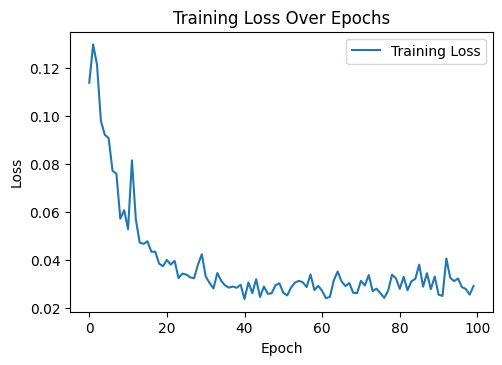

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

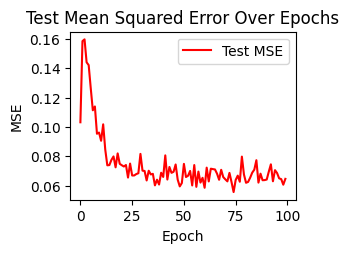

In [ ]:
plt.subplot(2, 2, 2)
plt.plot(test_mse, label='Test MSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Test Mean Squared Error Over Epochs')
plt.legend()
plt.show()

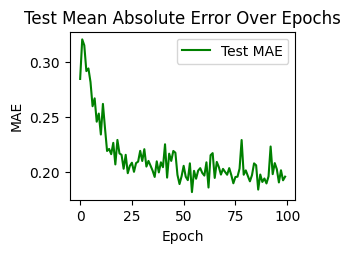

In [ ]:
plt.subplot(2, 2, 3)
plt.plot(test_mae, label='Test MAE', color='green')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test Mean Absolute Error Over Epochs')
plt.legend()
plt.show()

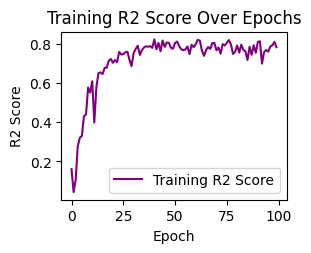

In [ ]:
plt.subplot(2, 2, 4)
plt.plot(train_r2_scores, label='Training R2 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Training R2 Score Over Epochs')
plt.legend()
plt.show()

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate R-squared score on the training set
with torch.no_grad():
        outputs = model(X_train)
        train_r2 = r2_score(y_train, outputs.squeeze())

print('Epoch [{}/{}], Train Loss: {:.4f}, Train R-squared: {:.4f}'.format(epoch+1, num_epochs, loss.item(),train_r2))

Epoch [100/100], Train Loss: 0.0176, Train R-squared: 0.7844


In [ ]:
# Test your model
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.squeeze().tolist())
        true_values.extend(batch_y.tolist())

mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
rmse = mean_squared_error(true_values, predictions, squared=False)
r2 = r2_score(true_values, predictions)

print('Mean Squared Error on test set:', mse)
print('Mean Absolute Error on test set:', mae)
print('Root Mean Squared Error on test set:', rmse)
print('R-squared Score on test set:',r2)

Mean Squared Error on test set: 0.0646318062782766
Mean Absolute Error on test set: 0.19593764463296304
Root Mean Squared Error on test set: 0.25422786290703187
R-squared Score on test set: 0.42812694968435894
